# 월마트 날씨별 판매량 예측

> ### 지점-아이템-날짜 기준으로 판매량(unit) 예측!

> - 일단 test.csv파일에 나와있는 항목들만 예측하도록 한다.

> - 학습은 train.csv파일에 있는 항목으로 진행한다.

> - output 형식은 sampleSubmission.csv파일의 내용을 참고한다
    - id, units = "2_1_2013-04-01" , int


In [1]:
#주피터노트북 그래프설정

%matplotlib inline
#주피터노트북에서 라인 아래에 보여지도록 설정

%config InlineBackend.figure_formats = {'png','retina'} 
#png 이미지 압축기술설정, retina 그래프 해상도 2배 높히기

#그래프 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc

#그래프 한글폰트 설정
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgunbd.ttf").get_name()
rc('font', family=font_name)
#음수처리
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
import os
import numpy as np
import pandas as pd

In [21]:
#전체기후날씨데이터(weather.csv) 불러오기
weather = pd.read_csv('weather.csv')
# weather["date"]=weather["date"].astype("datetime64[ns]") #-----열 선택하여 형변환
#지점-기후관측소 대조표(key.csv) 불러오기
map_key = pd.read_csv('key.csv')

#일일-지점-상품-판매량 정보(train.csv) 불러오기
store_data = pd.read_csv('train.csv')

#판매량 예측을 위한 지점정보(test.csv) 불러오기
test = pd.read_csv('test.csv')

In [4]:
#전체데이터 조합
    #1. store_data에 스테이션 넘버 부여
result_df = store_data.merge(map_key, left_on="store_nbr", right_on="store_nbr" )
cols = ['date', 'store_nbr', 'station_nbr', 'item_nbr', 'units']
new_df = result_df[cols] #열 위치변경된 것들

    #2. 종합세팅
all_set = new_df.merge(weather, left_on=["date","station_nbr"], right_on=["date","station_nbr"] )


In [136]:
#데이터확인칸
# 데이터타입 날짜화 및 int화(이거 안되면 에러나니까 꼭 타입정제부터 하자)
all_set["date"]=all_set["date"].astype("datetime64[ns]") #-----열 선택하여 형변환
all_set["avgspeed"] = pd.to_numeric(all_set["avgspeed"], errors='coerce')
all_set["tavg"] = pd.to_numeric(all_set["tavg"], errors='coerce')
all_set["dewpoint"] = pd.to_numeric(all_set["dewpoint"], errors='coerce')


In [137]:
# all_set.head()
all_set.dtypes

date           datetime64[ns]
store_nbr               int64
station_nbr             int64
item_nbr                int64
units                   int64
tmax                   object
tmin                   object
tavg                    int64
depart                 object
dewpoint                int64
wetbulb                object
heat                   object
cool                   object
sunrise                object
sunset                 object
codesum                object
snowfall               object
preciptotal            object
stnpressure            object
sealevel               object
resultspeed            object
resultdir              object
avgspeed                int64
dtype: object

In [80]:
#날씨테이블만 정리-도출하는 함수 제작-----------------------------------
#----1.기간-스테이션별 요소값 df도출 함수
#----2.기간-평균값 df도출 함수

#-------특정 날씨요소값의 날짜-관측소 데이터 도출함수
def weather_pivot(column_name):

    station_itm = pd.DataFrame(weather,columns=["station_nbr","date",column_name])

        # 스테이션별 피봇팅(테이블)
    station_value = station_itm.pivot("date","station_nbr",column_name)
    station_table = station_value.apply(pd.to_numeric, errors = 'coerce')

    return station_table
    


#--------날짜별 (숫자형)날씨요소 평균 도출함수---------
def weather_mean(column_name):
    station_itm = pd.DataFrame(weather,columns=["date","station_nbr",column_name])
        # 데이터타입 숫자화(이거 안되면 에러나니까 꼭 타입정제부터 하자)
    temp_df = station_itm.replace(["M",None],0)
    station_itm = temp_df.apply(pd.to_numeric, errors = 'ignore')
        # 평균구해넣기
    avg_df = station_itm.pivot_table(column_name,["date"], aggfunc=np.mean)
    avg_df = avg_df.apply(pd.to_numeric, errors = 'ignore')
    
    return avg_df


#--------스테이션별 전체날짜 평균 도출함수---------
def station_mean(column_name):
    station_itm = pd.DataFrame(weather,columns=["station_nbr","date",column_name])
        # 데이터타입 숫자화(이거 안되면 에러나니까 꼭 타입정제부터 하자)
    temp_df = station_itm.replace(["M",None],0)
    station_itm = temp_df.apply(pd.to_numeric, errors = 'ignore')
        # 평균구해넣기
    station_avg = station_itm.pivot_table(column_name,["station_nbr"], aggfunc=np.mean)
    station_avg = station_avg.apply(pd.to_numeric, errors = 'ignore')
    
    return station_avg



#=============================================================================

#지점별 avgspeed테이블 만들기 + mean speed 행 만들기--------------------------------
# station_wth = pd.DataFrame(weather,columns=["station_nbr","date","avgspeed"])


# station_speed = station_wth.pivot("date","station_nbr","avgspeed")
# station_speed = station_speed.replace(["M",None],0)

# station_speed = station_speed.astype(int, errors='ignore')



#----------이제 함수를 써보자!

#1. 이슬점온도
station_dewpoint = weather_pivot("dewpoint")
station_dewpoint_avg = weather_mean("dewpoint")

#2. 하루평균온도
station_temp = weather_pivot("tavg")
station_temp_avg = weather_mean("tavg")

#3. 하루평균 바람세기
station_speed = weather_pivot("avgspeed")
station_speed_avg = weather_mean("avgspeed")

#4. 기압도
station_pressure = weather_pivot("stnpressure")
station_pressure_avg = weather_mean("stnpressure")
station_pressure_eachavg = station_mean("stnpressure") #개별 스테이션별 평균 기압

In [102]:
# weather
# station_dewpoint
# station_dewpoint_avg
# station_temp
# station_temp_avg
station_pressure

station_nbr,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
date,,,,,,,,,,,,,,,,,,,,
2012-01-01,29.78,28.82,29.77,29.79,NaN,29.95,29.15,30.05,29.34,30.16,30.15,30.15,24.60,29.13,29.53,29.80,29.83,29.98,29.06,29.78
2012-01-02,29.44,28.51,29.89,29.93,NaN,30.09,29.23,30.25,29.67,30.11,30.10,30.09,24.55,29.21,29.20,29.48,29.96,30.11,29.47,29.90
2012-01-03,29.67,28.69,29.55,29.70,NaN,29.88,28.84,30.12,29.26,30.27,30.26,30.25,24.40,28.84,29.44,29.70,29.61,29.84,29.43,29.63
2012-01-04,29.86,28.87,29.53,29.55,NaN,29.72,28.90,29.90,29.26,30.35,30.34,30.34,24.49,28.89,29.63,29.90,29.59,29.75,29.21,29.54
2012-01-05,29.67,28.70,29.35,29.51,NaN,29.68,28.71,29.87,28.95,30.20,NaN,30.18,24.26,28.71,29.42,29.70,29.42,29.66,29.02,29.46
2012-01-06,29.68,28.71,29.16,29.26,NaN,29.44,28.51,29.65,29.00,30.14,30.12,30.12,24.21,28.50,29.46,29.72,29.23,29.39,28.95,29.19
2012-01-07,29.57,28.63,29.36,NaN,NaN,29.47,28.69,29.63,29.36,30.11,30.10,30.09,24.19,28.66,29.35,29.60,29.41,29.47,29.32,29.27
2012-01-08,29.90,28.95,29.45,29.31,NaN,29.47,28.78,29.64,29.42,30.17,30.17,30.16,24.32,28.76,29.67,29.93,29.50,29.56,29.53,29.34
2012-01-09,30.06,29.05,29.46,29.33,NaN,29.48,28.79,29.60,29.17,30.14,30.14,30.13,24.37,28.77,29.81,30.09,29.52,29.54,29.23,29.33


In [30]:
weather

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2012-01-01,52,31,42,M,36,40,23,0,-,-,RA FZFG BR,M,0.05,29.78,29.92,3.6,20,4.6
1,2,2012-01-01,48,33,41,16,37,39,24,0,0716,1626,RA,0.0,0.07,28.82,29.91,9.1,23,11.3
2,3,2012-01-01,55,34,45,9,24,36,20,0,0735,1720,,0.0,0.00,29.77,30.47,9.9,31,10.0
3,4,2012-01-01,63,47,55,4,28,43,10,0,0728,1742,,0.0,0.00,29.79,30.48,8.0,35,8.2
4,6,2012-01-01,63,34,49,0,31,43,16,0,0727,1742,,0.0,0.00,29.95,30.47,14.0,36,13.8
5,7,2012-01-01,50,33,42,M,26,35,23,0,-,-,,0.0,0.00,29.15,30.54,10.3,32,10.2
6,8,2012-01-01,66,45,M,M,34,46,M,M,-,-,RA BR,M,0.00,30.05,M,11.0,36,10.9
7,9,2012-01-01,34,19,27,M,17,23,38,0,-,-,UP,M,T,29.34,30.09,22.8,30,22.5
8,10,2012-01-01,73,53,63,M,55,58,2,0,0723,1738,FG+ FG BR,M,0.00,30.16,30.19,5.1,24,5.5
9,11,2012-01-01,72,48,60,7,54,56,5,0,0724,1737,FG+ FG BR,0.0,0.00,30.15,30.18,4.6,23,4.8


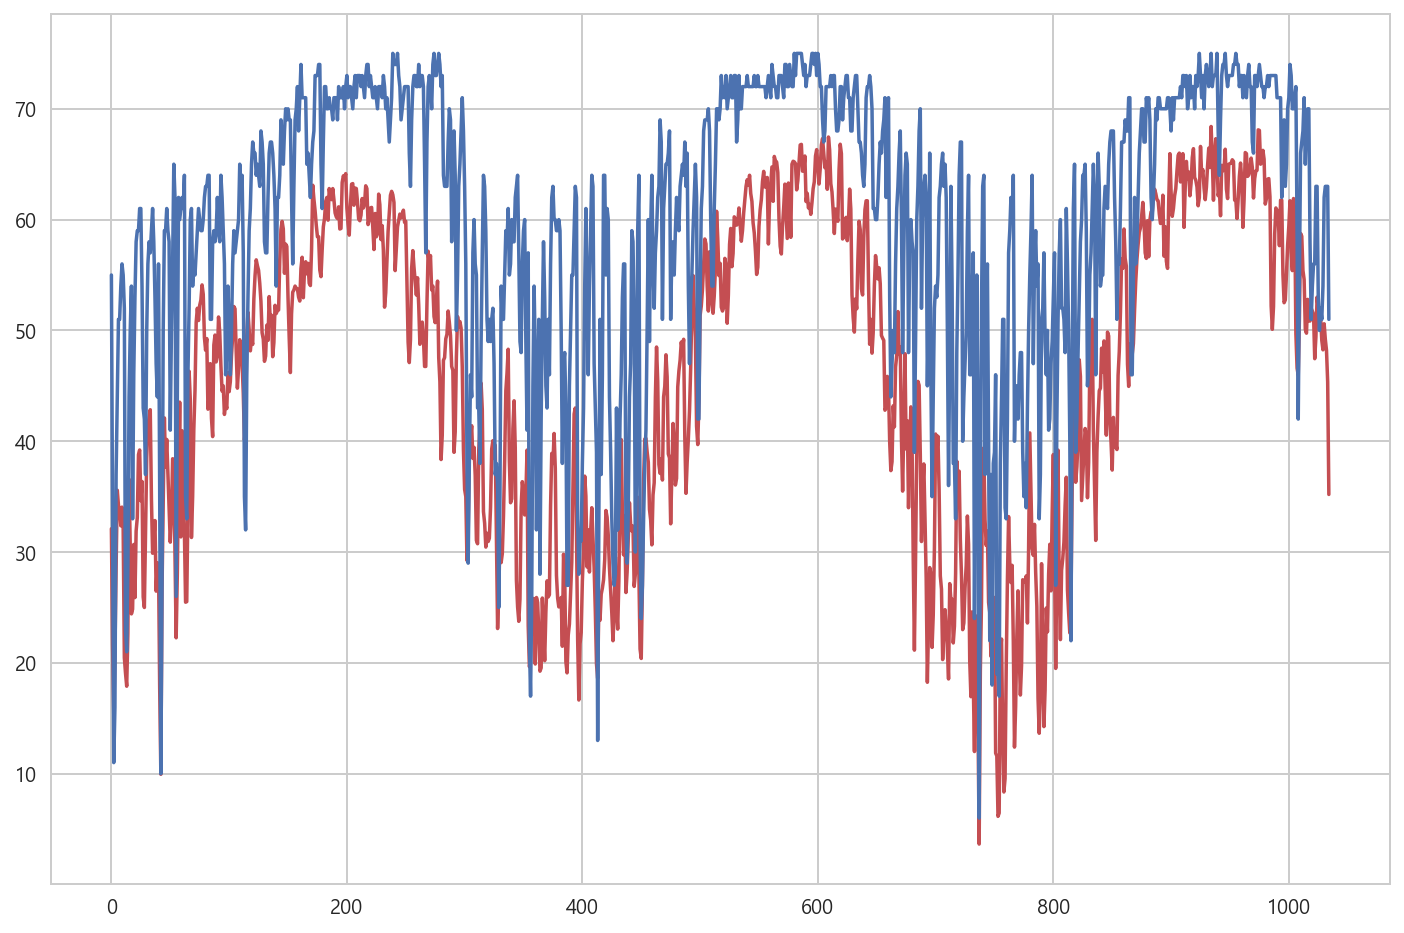

In [55]:
# plotchart - 날짜별 날씨요소 비교 시각화

plt.figure(figsize=(12,8))

#개별데이터
# y1 = station_heat[1]
# y2 = station_heat[18]
# y3 = station_heat[20]

#전체평균온도
Ya = station_dewpoint[10]
Y_dew = station_dewpoint_avg["dewpoint"]

plt.plot(range(len(Y_dew)),Y_dew, "r", range(len(Ya)),Ya, "b")
# plt.yticks([0,10,20,30,40,50,60])
# plt.scatter([range(len(y1)),range(len(y2)),range(len(y3))],[y1,y2,y3],c=["b","g","r"])

plt.show()

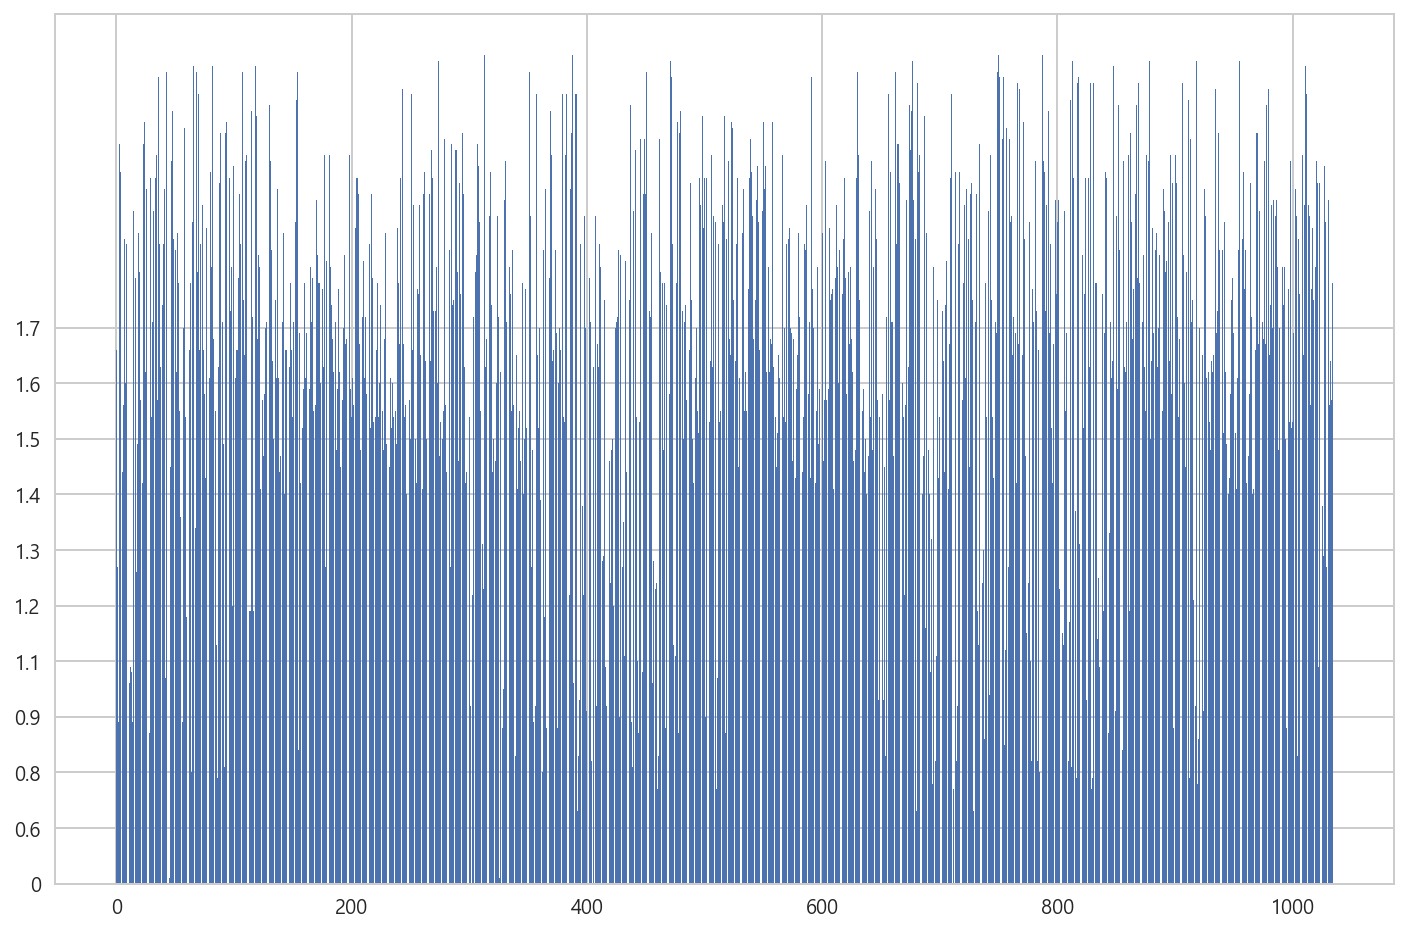

In [44]:
#barchart - 날짜별 날씨요소 변화

plt.figure(figsize=(12,8))
y1 = station_speed[1]
y2 = station_speed[18]
y3 = station_speed[20]
plt.bar(range(len(y1)),y1)
plt.yticks([0,10,20,30,40,50,60,70,80,90,100])
# plt.scatter([range(len(y1)),range(len(y2)),range(len(y3))],[y1,y2,y3],c=["b","g","r"])

plt.show()

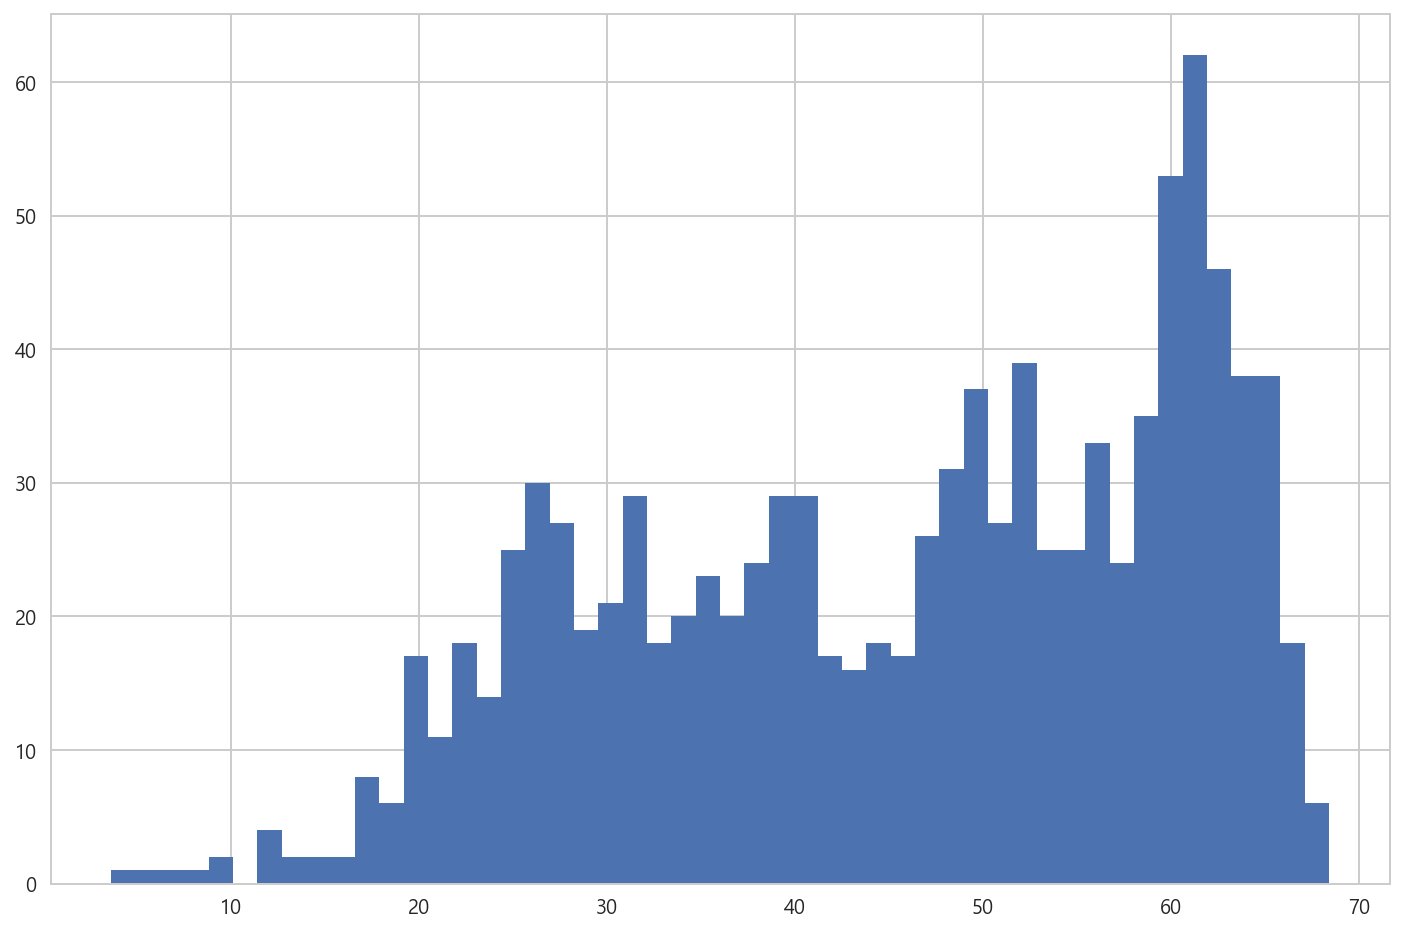

In [66]:
# histogram - 요소크기 분포도
plt.figure(figsize=(12,8))

Y = station_dewpoint_avg['dewpoint']

plt.hist(Y, bins = 50)
plt.show()

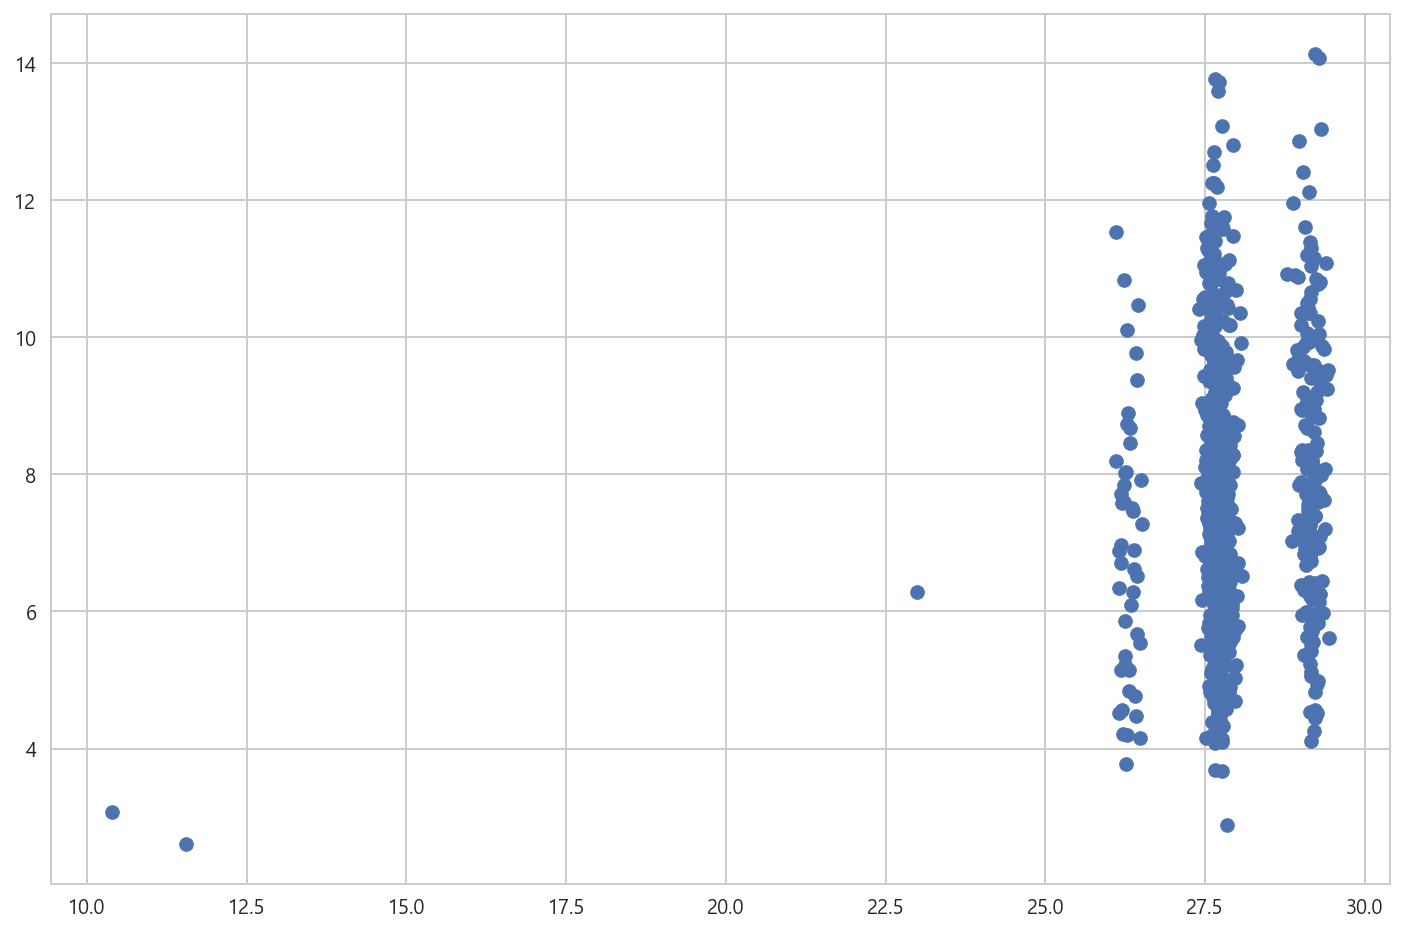

In [77]:
# scatter - 요소상관분포도

plt.figure(figsize=(12,8))

Y = station_speed_avg['avgspeed']
X = station_pressure_avg['stnpressure']
# plt.ylim(25,30)
plt.scatter(X,Y)

plt.show()



In [127]:
station_speed[1].values

array([  4.6,  10.3,  11.6, ...,   4.4,   3.7,   5.8])

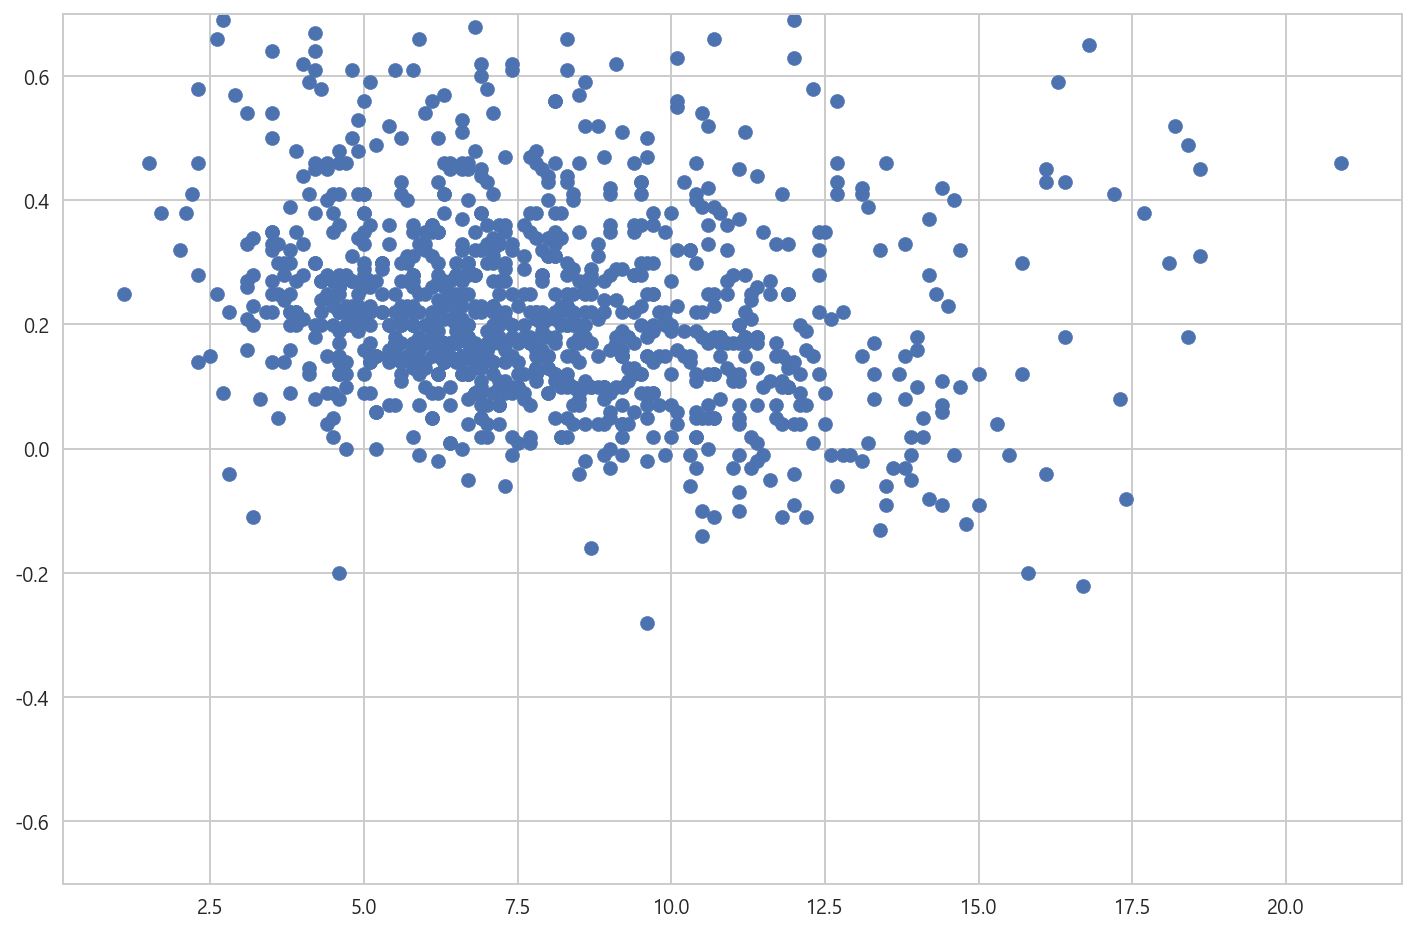

In [135]:
# scatter - station1의 기압 분산정도

plt.figure(figsize=(12,8))

Y = (station_pressure[20]-station_pressure_eachavg["stnpressure"][20]).values
X = station_speed[20].values

plt.ylim(-0.7,0.7)
plt.scatter(X,Y)

plt.show()



# 현재까지 알아낸 특성

1. 온도와 이슬점은 거의 매우 상관관계이다.
2. 온도와 바람세기는 거의 독립관계이다.
3. 스테이션별 기압은 고유의 범위를 가지고 있다. (고지대와 저지대의 차이로 볼수 있는듯)
4. 기압과 바람세기는 아주 미약한 반상관관계가 있다. (거의 상관이 없다)

In [138]:
all_set.dtypes

date           datetime64[ns]
store_nbr               int64
station_nbr             int64
item_nbr                int64
units                   int64
tmax                   object
tmin                   object
tavg                    int64
depart                 object
dewpoint                int64
wetbulb                object
heat                   object
cool                   object
sunrise                object
sunset                 object
codesum                object
snowfall               object
preciptotal            object
stnpressure            object
sealevel               object
resultspeed            object
resultdir              object
avgspeed                int64
dtype: object

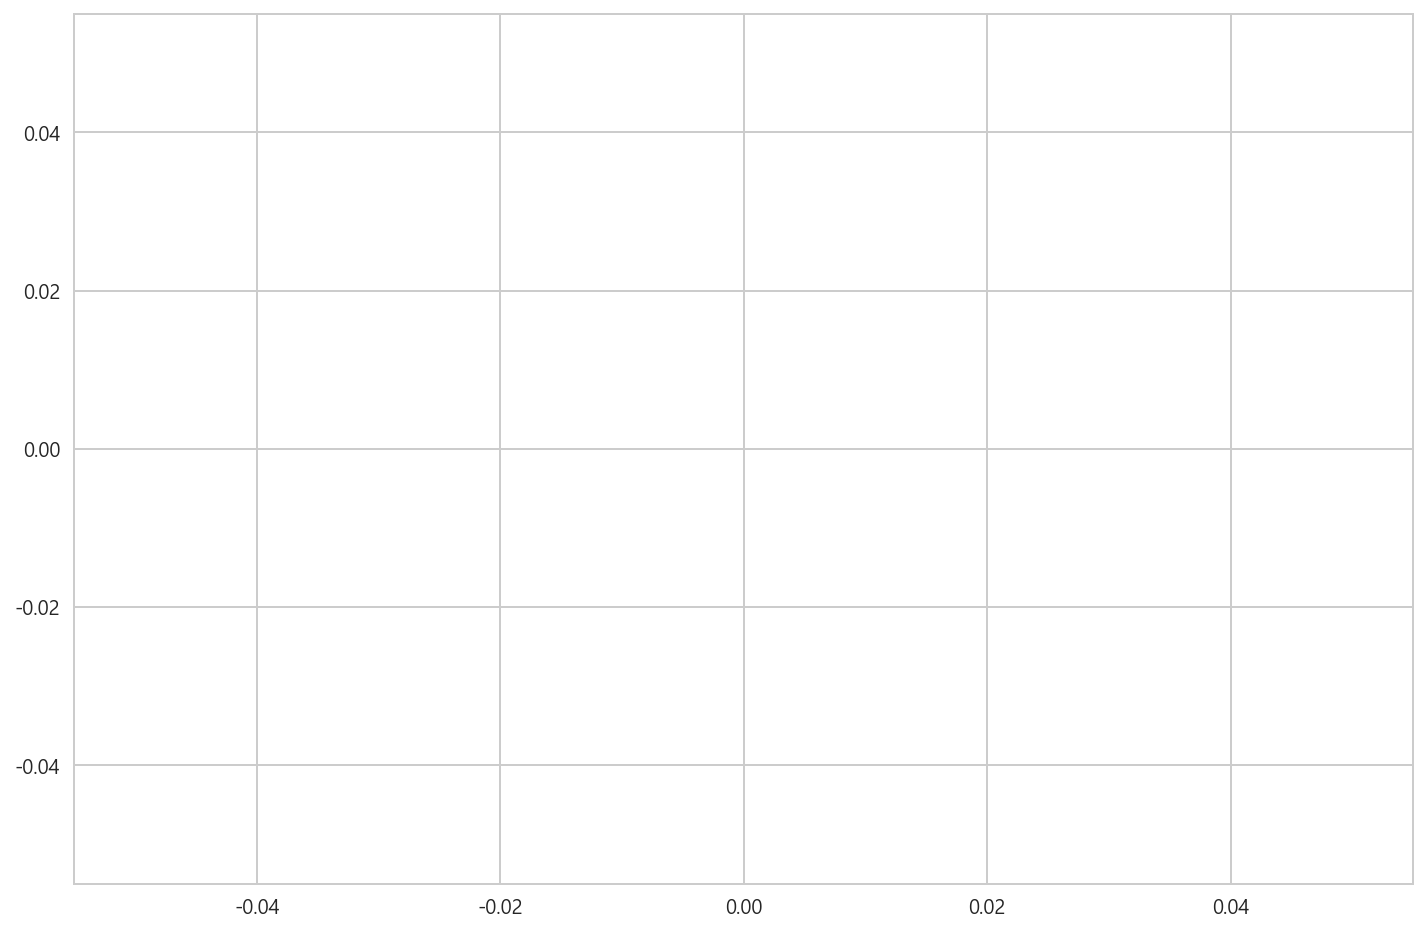

Series([], Name: store_nbr, dtype: int64)

In [145]:
# Seaborn으로 해보기

plt.figure(figsize=(12,8))

store1_items= all_set[all_set["store_nbr"] == 1]



X = store1_items["item_nbr"]

Y = store1_items["units"]

plt.scatter(X,Y)

plt.show()
all_set["store_nbr"]